This notebook provides an example for how to calculate the multi-model ensemble mean bias of CMIP6 data.

In [1]:
import os
import sys
       
import xarray as xr
xr.set_options(keep_attrs=True)
import numpy as np
import metpy.calc as mp

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

%config InlineBackend.figure_format = 'retina'
dpath0='/Users/dervlamk/OneDrive/research'
dpath1=f'{dpath0}/cmip'
dpath2=f'{dpath0}/topo_biases'
dpath3=f'{dpath0}/obs_data'

In [2]:
# Custom functions that are helpful

def get_season(season='ann'):
    """
    Index months to average over to derive an annual or seasonal mean
        - can only be applied to monthly climatologies
    """
    if season in ['ANNUAL', 'ANN', 'ann']:
        mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['DJF', 'djf']:
        mons = [0, 1, 11]
    if season in ['JFM', 'jfm']:
        mons = [0, 1, 2]
    if season in ['MAM', 'mam']:
        mons = [2, 3, 4]
    if season in ['JJA', 'jja']:
        mons = [5, 6, 7]
    if season in ['JJAS', 'jjas']:
        mons = [5, 6, 7, 8]
    if season in ['JAS', 'jas']:
        mons = [6, 7, 8]
    if season in ['SON', 'son']:
        mons = [8, 9, 10]
    if season==None:
        pass
    return mons

In [3]:
## Load CMIP6 ensemble precip data
filen='data/cmip6.pr.climo.nc'
P_MODELS=xr.open_dataset(f'{dpath1}/{filen}').pr.squeeze(drop=True)


## Load GISS E2.1 PI Control data
filen='model_output/e2pt1/cpld.e2.1.output.nc'
CTRL=xr.open_dataset(f'{dpath2}/{filen}').prec[0]
# convert lons from -180:180 to 0:360
nroll=int(len(CTRL.lon)/2)
CTRL=CTRL.roll(lon=nroll)
nx=len(CTRL.lon)
CTRL['lon']=np.linspace(0,360,nx)
CTRL=CTRL.interp_like(P_MODELS,method='linear')


## Load IMERG observational precip data
filen='obs_data/satellite/imerg/imerg.climo.gn.nc'
P_OBS=xr.open_dataset(f'{dpath0}/{filen}').precipitation
P_OBS.attrs['source_id']='IMERG'
# convert lons from -180:180 to 0:360
nroll=int(len(P_OBS.lon)/2)
P_OBS=P_OBS.roll(lon=nroll)
nx=len(P_OBS.lon)
P_OBS['lon']=np.linspace(0,360,nx)
P_OBS=P_OBS.interp_like(P_MODELS,method='linear')

In [4]:
seasons = ['djf','mam','jja','son']

OBS_P_MEAN = {}
MODELS_P_MEAN = {}
CTRL_P_BIAS = {}
MEAN_P_BIAS = {}
MEAN_P_BIAS_SIGN = {}

for seas in seasons:
    mons = get_season(seas)
    
    # calculate seasonal mean climo
    OBS_P_MEAN[seas] = P_OBS[(mons),:,:].mean(dim='month')
    MODELS_P_MEAN[seas] = P_MODELS[:,(mons),:,:].mean(dim='month')
    
    # calculate GISS E2.1 seasonal mean bias
    CTRL_P_BIAS[seas] = CTRL[(mons),:,:].mean(dim='month') - OBS_P_MEAN[seas]
    
    MODEL_P_BIAS = {}
    MODEL_P_BIAS_SIGN = {}
    # calculate bias and bias direction of CMIP6 models
    for i in np.arange(0,len(P_MODELS.source_id),1):
        # model bias
        MODEL_P_BIAS[seas] = MODELS_P_MEAN[seas][i] - OBS_P_MEAN[seas]
        if i==0:
            MEAN_P_BIAS[seas] = MODEL_P_BIAS[seas]
        else:
            MEAN_P_BIAS[seas] = xr.concat([MEAN_P_BIAS[seas], MODEL_P_BIAS[seas]], dim='source_id', coords='minimal')
        # sign of bias
        MODEL_P_BIAS_SIGN[seas] = np.sign(MODEL_P_BIAS[seas])
        if i==0:
            MEAN_P_BIAS_SIGN[seas] = MODEL_P_BIAS_SIGN[seas]
        else:
            MEAN_P_BIAS_SIGN[seas] = xr.concat([MEAN_P_BIAS_SIGN[seas], MODEL_P_BIAS_SIGN[seas]], dim='source_id', coords='minimal')

In [5]:
## Index where models agree

# initialize dicts
POSITIVE_MODEL_BIAS = {}
NEGATIVE_MODEL_BIAS = {}
N_POSITIVE = {}
N_NEGATIVE = {}
P_AGREEMENT_IDX = {}
# set threshold number of models that agree for multi-model mean to be significant
n_models=len(P_MODELS.source_id)*.75

# initialize array of ones
idx=xr.zeros_like(OBS_P_MEAN['djf'])

for seas in seasons:
    # create indices where the majority of models agree on direction of change
    POSITIVE_MODEL_BIAS[seas] = MEAN_P_BIAS_SIGN[seas].where(MEAN_P_BIAS_SIGN[seas]>0,np.nan)
    NEGATIVE_MODEL_BIAS[seas] = MEAN_P_BIAS_SIGN[seas].where(MEAN_P_BIAS_SIGN[seas]<0,np.nan)
    N_POSITIVE[seas] = POSITIVE_MODEL_BIAS[seas].sum(dim='source_id')
    N_NEGATIVE[seas] = np.abs(NEGATIVE_MODEL_BIAS[seas].sum(dim='source_id'))
    P_AGREEMENT_IDX[seas] = idx.where(((N_POSITIVE[seas]>=n_models) | (N_NEGATIVE[seas]>=n_models)), 1)

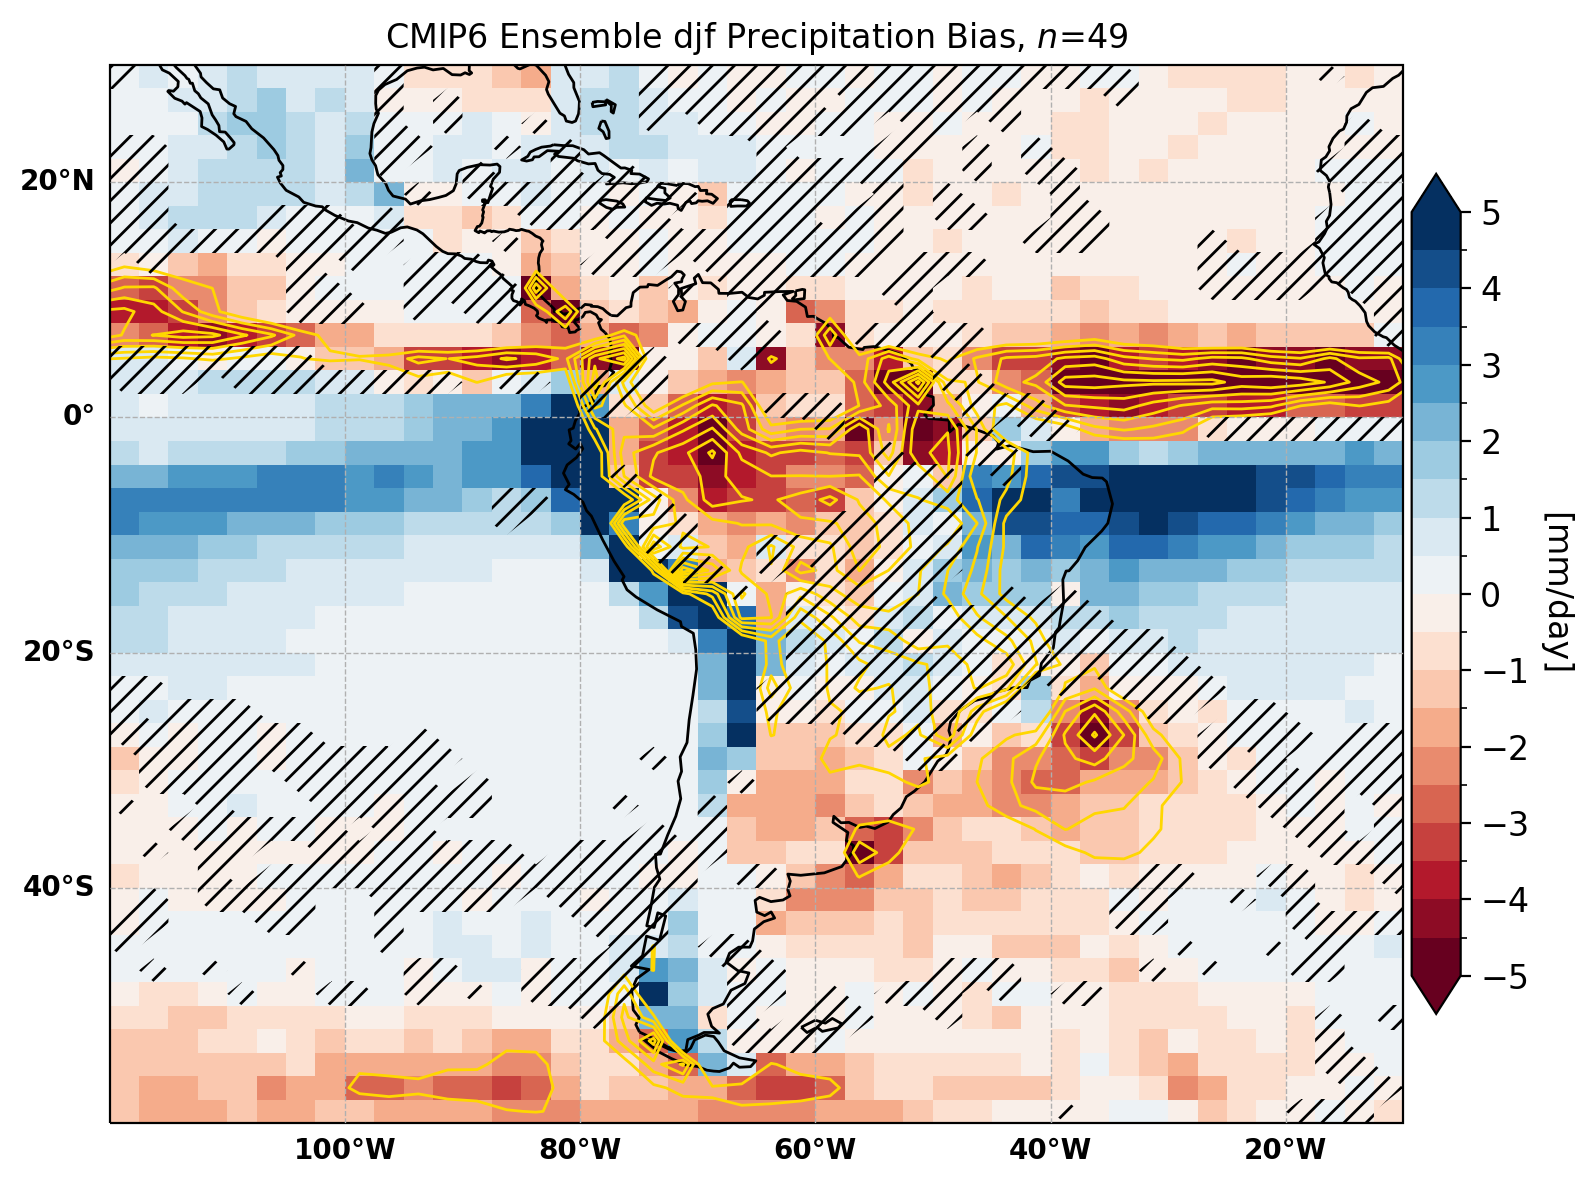

In [32]:
## Plot mean bias with hatching where models disagree
 
season='djf'

# colormap / contour info
pcmap=cm.RdBu
pvmin=-5
pvmax=5
pnorm=mpl.colors.BoundaryNorm(np.linspace(pvmin, pvmax, 21), pcmap.N)
plevels=np.linspace(5,15,11)

# map info
proj=ccrs.PlateCarree(central_longitude=180)
trans=ccrs.PlateCarree()
map_bnds=[240,350,-60,30]

# initialize figure
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(7,7), layout='constrained', subplot_kw={'projection': proj})

# set title
ax.set_title(f'CMIP6 Ensemble {season} Precipitation Bias, $n$=%i' %len(P_MODELS.source_id))

# plot Multi-Model Ensemble mean bias
cf=ax.pcolormesh(MEAN_P_BIAS[season].lon, MEAN_P_BIAS[season].lat,
                 MEAN_P_BIAS[season].mean(dim='source_id'),
                 norm=pnorm, cmap=pcmap, transform=trans) 

# add IMERG climatology contours
cs=ax.contour(OBS_P_MEAN[season].lon, OBS_P_MEAN[season].lat, OBS_P_MEAN[season],
              levels=plevels, linewidths=1, colors='gold', transform=trans)
#ax.clabel(cs, cs.levels, inline=True, inline_spacing=5, fontsize=7)

# add hatching for where <75% of models agree on sign of change
ax.contourf(P_AGREEMENT_IDX[season].lon, P_AGREEMENT_IDX[season].lat, P_AGREEMENT_IDX[season],
            1, colors='none',
            hatches=['','///'],
            extend='lower', zorder=100, transform=trans)

# map formatting
ax.coastlines(color='k')
ax.set_extent(map_bnds, crs=trans)
gl=ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.left_labels=True; gl.bottom_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'bold', 'size':10}
gl.ylabel_style={'color': 'black', 'weight': 'bold', 'size':10}

# colorbar
cax=fig.add_axes([1., 0.2, 0.035, 0.6])
cbar=fig.colorbar(cf, orientation='vertical', extend='both', cax=cax)
cbar.set_ticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
cbar.set_label('[mm/day]', labelpad=15, rotation=270, size=12, fontweight='normal', ha='center')
cbar.ax.tick_params(labelsize=12)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')
    
    
#plt.savefig(f'{dpath1}/figs/cmip6_pr_bias_imerg_{seas}.pdf', bbox_inches='tight', transparent=True)